In [12]:
import matplotlib.pyplot as plt
import numpy as np
from filter_data_helpers import get_halos_based_on_filters, get_profiles_for_halos

HUBBLE = 0.6711

In [13]:
# Select halos based on mass cut and simulation ID
halo_ids_result = get_halos_based_on_filters(
    list_of_inequality_filters=[("M_Crit200", 1/HUBBLE, 1e5/HUBBLE)],
    list_of_equality_filters=[("simulation_unique_id", ["IllustrisTNG_1P_22", "IllustrisTNG_LH_1"])]
)
print(halo_ids_result)

      snapshot simulation_unique_id   ID   M_Crit200   R_Crit200  \
0           33    IllustrisTNG_LH_1   28  226.114471  213.464172   
1           33    IllustrisTNG_LH_1   31  252.383682  221.428207   
2           33    IllustrisTNG_LH_1   47  125.484528  175.414001   
3           33    IllustrisTNG_LH_1   48  134.277542  179.425171   
4           33    IllustrisTNG_LH_1  169   26.638687  104.644287   
...        ...                  ...  ...         ...         ...   
1318        32   IllustrisTNG_1P_22  363   14.830034   88.927475   
1319        32   IllustrisTNG_1P_22  375   13.004515   85.115128   
1320        32   IllustrisTNG_1P_22  407   12.435729   83.858856   
1321        32   IllustrisTNG_1P_22  473   11.928513   82.703941   
1322        32   IllustrisTNG_1P_22  482   10.903000   80.257217   

      GroupFirstSub       sfr     mstar  GroupBHMass  GroupBHMdot  ...  \
0            1795.0  0.219497  1.311085     0.009072     0.009072  ...   
1            1842.0  0.000000  2.39

In [14]:
# Select profiles for the filtered halo IDs
profiles_result = get_profiles_for_halos(
    list_of_halos=halo_ids_result[["ID", "simulation_unique_id", "snapshot"]],
    list_of_properties=["gas_density"] # See options in illstack_helpers.py, or enter [] to receive all available profiles
)

print(profiles_result)

SELECT * FROM profiles WHERE simulation_unique_id = 'IllustrisTNG_LH_1' AND snapshot = 33 AND property_key IN ('gas_density') AND ID IN (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195

In [15]:
# Rescale data to common units
profiles_result["radius"] *= 1 / (HUBBLE * 1e3) # Convert to Mpc
profiles_result["property_value"] *= 1e10 * HUBBLE * HUBBLE # Convert to Msun * kpc^-3

# Plot profiles for different halos

# Filter radial values
profiles_result = profiles_result[(profiles_result["radius"] > 0.01) & (profiles_result["radius"] < 3)]
print(profiles_result)

                                ID    radius property_key  property_value
simulation_unique_id snapshot                                            
IllustrisTNG_1P_22   32          0  0.017138  gas_density    74857.179529
                     32          0  0.029783  gas_density    46904.702661
                     32          0  0.051757  gas_density    31918.016471
                     32          0  0.089944  gas_density    22804.697955
                     32          0  0.156305  gas_density    16590.794011
...                            ...       ...          ...             ...
IllustrisTNG_LH_1    33        404  0.258948  gas_density      106.363617
                     33        404  0.450000  gas_density      126.047135
                     33        404  0.782011  gas_density      139.641017
                     33        404  1.358979  gas_density       35.756617
                     33        404  2.361635  gas_density        5.228295

[13230 rows x 4 columns]


In [16]:
# Bin halo_IDs by M_Crit200
mass_ranges = [(1, 2), (2, 10), (10, 100), (100, 1000)]
halo_IDs_bins = [list(halo_ids_result[(halo_ids_result["M_Crit200"] >= low) & (halo_ids_result["M_Crit200"] < high)]["ID"]) for (low, high) in mass_ranges]
print(halo_IDs_bins)

# Convert units
label_mass_ranges = [(1e10*low/HUBBLE, 1e10*high/HUBBLE) for (low, high) in mass_ranges]

[[], [], [169, 205, 208, 215, 225, 263, 274, 290, 293, 304, 309, 323, 361, 364, 391, 77, 139, 176, 242, 281, 349, 59, 62, 63, 83, 84, 112, 116, 160, 162, 170, 180, 185, 198, 199, 212, 252, 256, 266, 297, 317, 336, 341, 68, 110, 133, 142, 148, 165, 168, 216, 224, 243, 284, 287, 312, 73, 93, 131, 149, 167, 179, 190, 246, 275, 292, 305, 313, 376, 75, 90, 97, 154, 177, 197, 214, 218, 228, 231, 235, 253, 269, 359, 58, 81, 85, 119, 132, 219, 286, 291, 307, 308, 327, 358, 67, 82, 89, 91, 95, 103, 105, 121, 147, 150, 184, 189, 196, 229, 236, 249, 270, 282, 301, 344, 345, 348, 374, 70, 145, 153, 156, 191, 203, 206, 244, 245, 294, 296, 318, 379, 108, 117, 163, 164, 166, 172, 174, 239, 306, 60, 111, 114, 120, 211, 223, 234, 334, 125, 155, 194, 207, 227, 230, 233, 261, 267, 357, 71, 113, 262, 268, 299, 322, 66, 137, 173, 204, 55, 100, 123, 141, 157, 213, 248, 257, 258, 289, 314, 320, 363, 372, 381, 78, 94, 126, 183, 195, 209, 238, 264, 280, 303, 324, 328, 332, 158, 271, 316, 347, 87, 98, 104, 127,

In [17]:
# Obtain all unique (simulation, snapshot) combinations in profiles dataset
sim_snap_combinations = profiles_result.index.drop_duplicates().to_numpy()

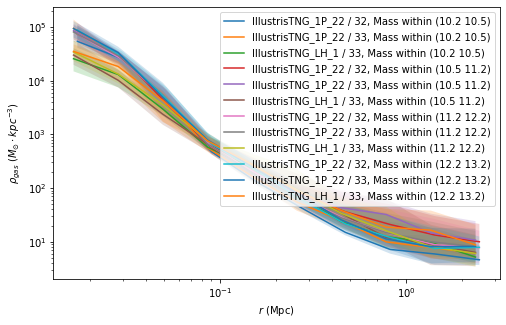

In [18]:
# Compute and plot percentiles of profile data
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for mass_range in label_mass_ranges:
    low, high = np.log10(mass_range)

    halos_filtered = halo_ids_result[(halo_ids_result["M_Crit200"] >= low) & (halo_ids_result["M_Crit200"] < high)]

    for sim, snapshot in sim_snap_combinations:
        # Determine halo IDs within this simulation and snapshot
        sim_snap_halo_ids = halos_filtered[(halos_filtered["simulation_unique_id"] == sim) & (halos_filtered["snapshot"] == snapshot)]["ID"]
        # Determine profiles for this simulation and snapshot (use .loc since (simulation, snapshot) is the MultiIndex for the profiles DataFrame)
        sim_snap_profiles = profiles_result.loc[(sim, snapshot)]
        # Filter profiles based on halo IDs
        sim_snap_profiles = sim_snap_profiles[sim_snap_profiles["ID"].isin(sim_snap_halo_ids)]
        # Only keep radius and property_value columns
        sim_snap_profiles = sim_snap_profiles[["radius", "property_value"]]

        # Determine median and percentiles for the profile data, and plot
        median_profiles = sim_snap_profiles.groupby("radius", as_index=False).median()

        ax.plot(
            median_profiles["radius"],
            median_profiles["property_value"],
            label=f"{sim} / {snapshot}, Mass within ({low:.1f} {high:.1f})"
        )

        # Display quantiles
        profiles_16 = sim_snap_profiles.groupby("radius", as_index=False).quantile(q=0.16)
        profiles_84 = sim_snap_profiles.groupby("radius", as_index=False).quantile(q=0.84)
        ax.fill_between(profiles_16["radius"], profiles_16["property_value"], profiles_84["property_value"], alpha=0.2)

# Display plot
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$r$ (Mpc)")
ax.set_ylabel(r"$\rho_{gas}$ ($M_{\odot} \cdot kpc^{-3}$)")

plt.legend()
plt.show()